In [29]:
import math
import geopy

In [18]:
# Calculate the Satellite's FoV: Implement a function to calculate the FoV based on the satellite's altitude, latitude, and longitude. This involves geometric calculations to map the satellite's position to a surface area on Earth.
# Filter CERES Data Based on FoV: Modify your plotting functions to only plot the data that falls within the satellite's FoV. This will likely involve filtering the latitude and longitude arrays based on the calculated FoV.
# Time-Dependent Processing: Implement a system that updates the satellite's position and FoV at regular intervals (e.g., every 5 minutes), and then plots the corresponding visible CERES data.

In [19]:

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

# Example usage with dummy coordinates
dummy_latitude = 0    # degrees
dummy_longitude = 0   # degrees
dummy_altitude = 15000  # kilometers

fov_boundaries = calculate_satellite_fov(dummy_latitude, dummy_longitude, dummy_altitude)
fov_boundaries

(-90, 90, -180, 180)

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

In [21]:
# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 400 # kilometers

# Calculate FoV
min_lat, max_lat, min_lon, max_lon = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/2326570468.py:25: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/2326570468.py:25: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]


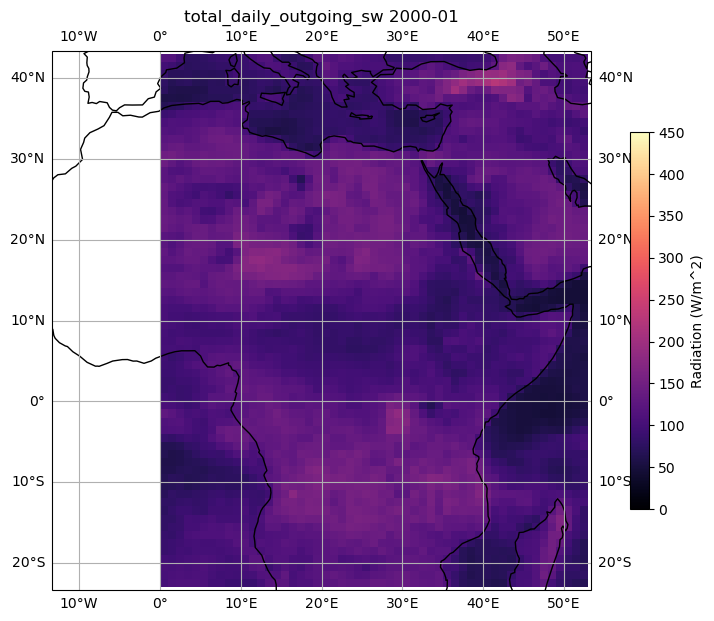

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 1000 # kilometers

# Calculate FoV
min_lat, max_lat, min_lon, max_lon = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

# Define the variable name and time index for the plot (as per your data)
variable_name = "total_daily_outgoing_sw" # example variable name
time_index = 0 # example time index

# Define the output folder for the plots
output_folder = "path/to/output/folder"


# Replace this with the actual path to your CERES dataset file
dataset_path = 'data/CERES_EBAF-TOA_Ed4.2_Subset_200003-202308.nc'
import netCDF4 as nc
# Load the dataset
data = nc.Dataset(dataset_path)

# Extract the radiation data, latitude, and longitude from the dataset
# Replace 'radiation_variable_name' with the actual variable name from your dataset
radiation_data = data.variables['toa_sw_all_mon'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]


# Plot the FoV radiation data
plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/1402956808.py:69: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/1402956808.py:69: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]


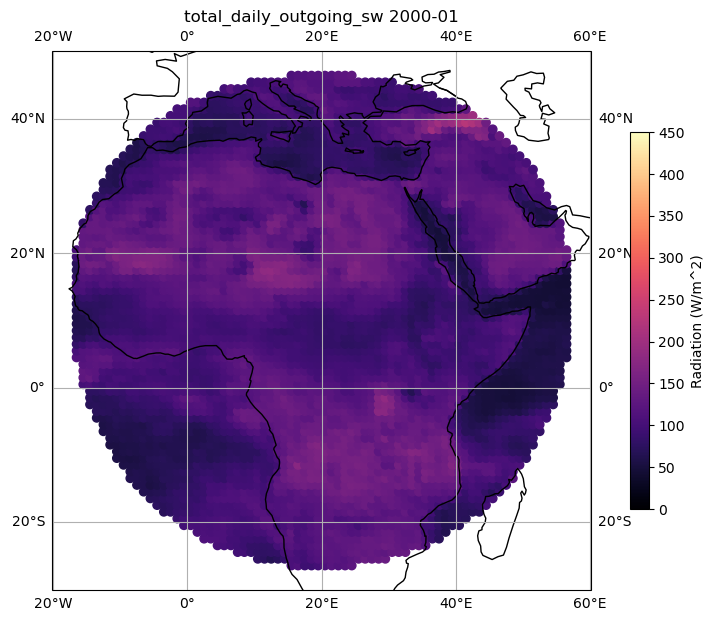

In [45]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geopy.distance import great_circle

def is_within_fov(sat_lat, sat_lon, horizon_dist, point_lat, point_lon):
    """
    Check if a point is within the satellite's field of view.
    """
    distance = great_circle((sat_lat, sat_lon), (point_lat, point_lon)).kilometers
    return distance <= horizon_dist

def plot_fov_radiation_scatter(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, horizon_dist, output_path):
    # Initialize an empty list to hold the radiation values within the FoV
    lat_points, lon_points, radiation_points = [], [], []

    # Iterate over the grid and collect data points within the FoV
    for i in range(len(lat)):
        for j in range(len(lon)):
            if is_within_fov(sat_lat, sat_lon, horizon_dist, lat[i], lon[j]):
                lat_points.append(lat[i])
                lon_points.append(lon[j])
                radiation_points.append(radiation_data[time_index, i, j])

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    scatter_plot = ax.scatter(lon_points, lat_points, c=radiation_points, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(scatter_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')
    plt.savefig(output_path)
    plt.close(fig)
    plt.show()

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    return horizon_distance_km

# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 1200 # kilometers

# Calculate horizon distance for FoV
horizon_distance_km = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

# Load the dataset
import netCDF4 as nc
data = nc.Dataset('data/CERES_EBAF-TOA_Ed4.2_Subset_200003-202308.nc')

# Extract the radiation data, latitude, and longitude from the dataset
radiation_data = data.variables['toa_sw_all_mon'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

# Define the variable name and time index for the plot
variable_name = "total_daily_outgoing_sw" # example variable name
time_index = 0 # example time index

# Define the output folder for the plots
output_folder = "FOV_sliced_data"

# Plot the FoV radiation data
plot_fov_radiation_scatter(variable_name, time_index, radiation_data, lat, lon, satellite_latitude, satellite_longitude, horizon_distance_km, output_folder)

In [44]:
import os

altitudes = [1000, 1000, 1000, 1000, 1000]
lats = [0, 0, 0, 0, 0]
lons = [0, 5, 10, 15, 20]

output_folder = "path/to/output/folder"
os.makedirs(output_folder, exist_ok=True)

# Ensure that 'lat' and 'lon' are arrays representing the latitude and longitude grid of the CERES data
# Example:
# lat = data.variables['lat'][:]
# lon = data.variables['lon'][:]

for idx, (alt, sat_lat, sat_lon) in enumerate(zip(altitudes, lats, lons)):
    horizon_distance_km = calculate_satellite_fov(sat_lat, sat_lon, alt)
    plot_filename = os.path.join(output_folder, f'fov_frame_{idx}.png')
    plot_fov_radiation_scatter("total_daily_outgoing_sw", 0, radiation_data, lat, lon, sat_lat, sat_lon, horizon_distance_km, plot_filename)


TypeError: object of type 'int' has no len()